# GMIT HDip Data Analytics; Machine Learning and Statistics; Project  
Read data from a csv file containing two values - speed and power - for the power generated by a wind turbine(s) according to wind speed. 

Create a web application and Python Flask server for the user to get predicted values from the web page (separate from this notebook).  

Let a user input wind speeds, and provide predictions of expected power using a machine learning model.

Start by reading in the csv file [1] and looking at the data:  
[1] Load data from txt with Pandas ; https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('powerproduction.txt', sep=",")

print(df)
c0 = df.columns[0]
c1 = df.columns[1]

      speed  power
0     0.000    0.0
1     0.125    0.0
2     0.150    0.0
3     0.225    0.0
4     0.275    0.0
..      ...    ...
495  24.775    0.0
496  24.850    0.0
497  24.875    0.0
498  24.950    0.0
499  25.000    0.0

[500 rows x 2 columns]


The first and last few entries all have power 0.0. Check some values from the middle of the data set :

In [4]:
print(df[245:255])

      speed   power
245  12.387  37.159
246  12.412  52.952
247  12.462  44.745
248  12.487  44.735
249  12.538  44.801
250  12.563  42.336
251  12.588  54.079
252  12.613  51.471
253  12.663  44.880
254  12.713  51.149


Plot the data using Seaborn, to get a visual image of it [2] :  
[2] Week 4 notes, Models, Train; GMIT Data Analytics HDip ; Machine Learning and Statistics notes

C:\Users\dingl\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


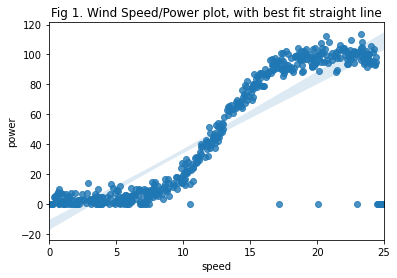

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=c0,y=c1,data=df)
plt.title("Fig 1. Wind Speed/Power plot, with best fit straight line")
plt.show()

The straight line doesn't provide a great fit to the data. There is a clear 's' shaped appearance displayed in the plot of the data above. Consider the plots of first order (y = x), second order (y = x^2) and third order polynomials (y = x^3) :

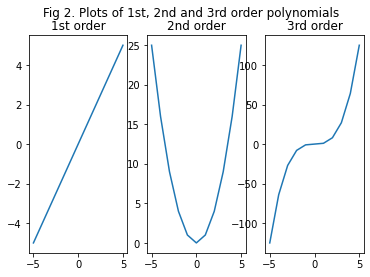

In [7]:
x = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
y1 = [number      for number in x]
y2 = [number ** 2 for number in x] 
y3 = [number ** 3 for number in x]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Fig 2. Plots of 1st, 2nd and 3rd order polynomials')
ax1.plot(x, y1)
ax1.set_title('1st order')
ax2.plot(x, y2)
ax2.set_title('2nd order')
ax3.plot(x, y3)
ax3.set_title('3rd order')
plt.show()

The straight line is the first order, like the regression line in the plot above. The shape of the 3rd order plot best fits the plot of the actual data, so we'll try applying a third order polynomial to get a best fit line [3] :   
[3] Fitting different kinds of models; https://seaborn.pydata.org/tutorial/regression.html

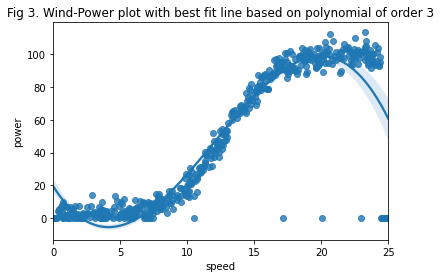

In [9]:
sns.regplot(x=c0,y=c1,data=df, order=3)
plt.title("Fig 3. Wind-Power plot with best fit line based on polynomial of order 3")
plt.show()

This gives a better fit, but there are some power values that don't fit the curve too well at the bottom and top ranges of the speed, and a few in the middle. Lets try a higher order polynomial - 5 -

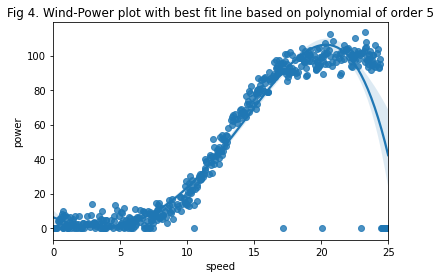

In [11]:
sns.regplot(x=c0,y=c1,data=df, order=5)
plt.title("Fig 4. Wind-Power plot with best fit line based on polynomial of order 5")
plt.show()

This gives a better fit for low speed values, but is still inaccurate for high values. The misfit top and bottom values are due to there being zero power output at wind speeds below a certain minimum value (the cut-in speed) and above a certain maximum value (the cut-out speed). The cut-in speed is due to there being insufficient torque to overcome friction within the turbine mechanism[4]. The cut-out speed prevents damage to the turbine by ensuring maximum structural loads within drive train components are not exceeded [5] The zero values for power mid-range are unexplained, but are probably due to the turbine(s) being turned off deliberately for routine maintenance or repair, or perhaps if power supply is exceeding demand [6]. For someone using the data a separate analysis of the frequency and duration of these mid-range zero power values would probably be appropriate to conduct. When the user runs this code to get predicted power values, two results will be presented - one that includes the mid-term zero values and one that excludes them - we do not know which is most useful. The cut-in and cut-out values will be displayed to the user on the web page, and if they enter wind speeds below or above these respectively the predicted power output will simply be output as 0.  
Create two linear regressin models using sklearn - one based on the straight line best fit, and the other on a polynomial.  
Plot the data with the zero values removed to see how the regression line looks without them.  
Also display the 'score' for the model - a measure of how well the predicted values match the actual values, with '1'
being a perfect fit [7]. See what predictions the two models make for a wind speed with value '8' - in Figure 1 the 
line of regression is approximately at a maximum deviation from the actual values. 
[4] Power curve ; https://www.sciencedirect.com/topics/engineering/power-  coefficient#:~:text=4.7.,are%20specified%20on%20power%20curves.
[5] https://www.windpowerengineering.com/how-turbulent-wind-abuse-wind-turbine-drivetrains/
[6] https://www.quora.com/In-a-field-of-wind-turbines-why-are-there-a-few-that-do-not-move  
[7] https://stackoverflow.com/questions/24458163/what-are-the-parameters-for-sklearns-score-function

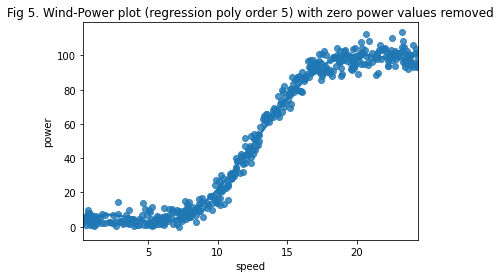

model1 score -  0.8984832870534454
model2 score -  0.9879782627661895
model1 prediction for  8  -  [25.11293725]
model2 prediction for  8  -  [7.99091135]


In [15]:
# Import sklearn libraries to build models that predict power output from wind speed input
# Polynomial regression ; https://scikit-learn.org/stable/modules/linear_model.html
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lin

# Set up two functions for making preictions based on the two models we're creating
def f(x,p):
    return p[0] + x*p[1]

def predict(s):
    return f(s,p)

# create numpy arrays of speed and power values
s = df["speed"].to_numpy()
po = df["power"].to_numpy()

# Find the minimum and maxiumum wind speeds below and above which power output is always zero. Also, note the index of 
# other entries in the dataset between the min and max where the power output is zero - turbine is offline
i = 0
ix = []
ix2 = []
minP = 0
maxP = 0
for px in po:
    if px == 0:
# Get the index for zero power output
        ix.append(i)
    else:
        maxP = s[i]
        maxI = i
        if minP == 0:
            minP = s[i]
            minI = i
    i+=1

# Append a list of all the indices for entries in the dataset bove and below the minimum value to 'ix2'    
for i in ix:
    if i < minI or i > maxI:
       ix2.append(i) 

# Create a dataset that excludes entries that are below the min or above the max wind speeds (with zero power output)
# and associated numpy arrays for speed and power
s2   = np.delete(s, ix2)
po2  = np.delete(po, ix2)
df2  = df.drop(ix2,axis=0)

# Create another dataset/numpy arrays with all entries removed where power output is zero
s  = np.delete(s, ix)
po = np.delete(po, ix)
df = df.drop(ix,axis=0)

# Plot the data with all zero power values removed
sns.regplot(x=c0,y=c1,data=df, order=5)
plt.title("Fig 5. Wind-Power plot (regression poly order 5) with zero power values removed")
plt.show()

# Create two models. The first based on the linear best fit regression line, the second using a polynomial
# ref Polynomial regression ; https://scikit-learn.org/stable/modules/linear_model.html
s = s.reshape(-1,1)
model1 = lin.LinearRegression()
model2 = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])

# Now train the two models using the dataset with entries removed where the power value is zero.
# Get the scores for the models - a measure of how well it fits the actual data - and display them
model1.fit(s,po)
r = model1.score(s,po)
print("model1 score - ",r)
p = [model1.intercept_ , model1.coef_]

model2.fit(s,po)
r = model2.score(s,po)
print("model2 score - ",r)

# Check what predictions the two models make for an input wind speed of 8 Km/H - as mentioned above, roughly the value 
# of wind speed where the best fit straight line differs most from the actual values.
testVal = 8

print("model1 prediction for ",testVal," - ",predict(testVal))

arr = np.array([testVal])
arr = arr.reshape(-1,1)

print("model2 prediction for ",testVal," - ",model2.predict(arr))


This looks like a good fit now with the zero values removed, and we can see that the 'score' is much closer to 1
for the polynomial of order 5 (model 2) than it is for the straight line fit (model 1) - giving a quantitative confirmation of the predictions better fitting the data. Also, looking at the plot we see the prediction for a wind speed of 8 is clearly much better for model 2 than for model 1.   

Note : In order for the model to be of use to the user, information would be required concerning the data provided, and the data source, depending on the nature of the user.  Many factors may influence the values, for example : 

Is the data from one turbine, or many turbines - what type of turbine is it from; if from many, how many, and of what model types and over what geographical area are they spread.
Where and when were the data gathered - turbulence effects may be more common in some locations, or at certain times of the year than others, and may affect power output, as may altitude which affects air density.
Where were the power measurements taken relative to the turbine - locally, or at a distance, and where and how was the wind speed measured. If the power measurements were not local what are the estimated transmission losses.
What instrumentation was used for the measurements, and when and how was it calibrated.  
Might other climatic factors affect the results, such as temperature.  
What is the data source, eg an academic study, the turbine manufacturer, an oil industry company - political attitudes may cast into question whether the figures are biased eg perhaps taken from a turbine that is known to have a technical problem or to be a particularly efficient or inefficient model.  
If the user of the data is for example a physicist/engineer carrying out research into turbines they may also want to know detailed information about all aspects of particular components of the turbine. It should be made clear who the target audience is for the data, so that the appropriate accompanying information can be provided.


We'll now use a Keras neural network machine learning algorithm for predicting power values for given input values (wind speed)(as demonstrated in course lectures), and compare the predictions with ones from the sklearn model. The neural network consists of an input layer (our 'speed' values in the input dataset), one or more 'hidden' layers of neurons, and the output layer (the 'power' values). Connections between neurons are allocated 'weights', and a bias can be applied to each layer. The model uses a training dataset, and the data are passed through the model multiple times whilst the algorithm keeps amending the values of the weights and biases to provide as close a match as possible to actual outputs when the model predicts resultant values based on the input training data.   
  
First we'll split the dataset into two parts - training (70% of values) and testing (30% of values), then create and train an sklearn and a Keras model using the training values, before checking the predictions of the two models using the test data.  

For the Keras neural network :
We have one dimensional input and output variables, and consequently the Sequential model is the most appropriate to use [8]. 

We'll use the Dense layer type, the most comonly used one, where each neuron is connected to every neuron in the preceeding layer, and that applies the formula 'output = activation(dot(input, kernel) + bias)' where 'kernel' is the matrix of weights applied to the connections between neurons - the model type discussed in lectures. We only have one column in our input data, causing our input shape (the dimension of the tensor passed between neurons) to be (1,) [9].  

Also, we'll use the 'sigmoid' activation function - we know there is a non-linear relationship between our input and output (speed/power) variables, and with sigmoid being non-linear it enables our network to 'learn' about this relationship [10]. Other activation functions could also be used, to return similar levels of accuracy - they may require the dataset to be passed through the network a different number of times (the number of 'epochs') to get to a steady state.  

Setting initial values for the weights (that connect the neurons) to 'glorot_uniform', should provide a start point for efficient, stable processing (a distribution centred around zero, with low variance) [11], [12]. Different distributions for initialising bias values are of less importance, with little difference between options. We'll set them both to glorot_uniform. 

As minor changes are made to the weights each time the input training values are passed through the network (one 'epoch') we'll specify the mean squared error as being the value we're trying to minimise (the mean of the square of the difference between actual and predicted values produced by passing the input values through the network 'epochs' number of times) [13].  
The 'Adam' algorithm has been shown to be one of the most efficient for this process, which is the one we'll use here[14].   
  
Different authors suggest that experimentation and intuition should be used to determine the best configuration of nodes and layers rather than there being clearly defined steps to obtain an optimal model [15][16][17]. For each epoch the 'Loss' value (sum of the mean squared errors for each output value) is reported to the console. As running the algorithm can take a little while, this has already been done with different parameter values, yielding :  

| Number of Nodes       | Number of Layers     | Number of Epochs     | Loss         |
| :-------------        | ----------:          | -----------:         | -----------: |
|  1                    | 1                    | 100                  | 3890         |
|  1                    | 1                    | 500                  | 3929         | 
|  10                   | 1                    | 100                  | 2486         |
|  10                   | 1                    | 500                  | 145          |
|  50                   | 1                    | 100                  | 666          |
|  50                   | 1                    | 500                  | 27           |
|  100                  | 1                    | 500                  | 39           |
|  50                   | 1                    | 700                  | 23           |
|  50                   | 1                    | 800                  | 19           |
|  50                   | 1                    | 1000                 | 18           |
|  7 / 7                | 2                    | 1000                 | 17           |   
  
There is little improvement above 500 epochs, and a very minor difference between having two layers of 7 nodes each rather
than one layer of 50 nodes. Samller numbers of nodes (1 and 10) yield much higher losses and are consequently insufficient
for producng good predictions. Here we'll use a single layer with 50 nodes and 500 epochs (to save on processing time).

[8] https://keras.io/guides/sequential_model/  
[9] https://datascience.stackexchange.com/questions/53609/how-to-determine-input-shape-in-keras  
[10] https://towardsdatascience.com/exploring-activation-functions-for-neural-networks-73498da59b02  
[11] https://deeplizard.com/learn/video/8krd5qKVw-Q  
[12] https://becominghuman.ai/priming-neural-networks-with-an-appropriate-initializer-7b163990ead  
[13] https://www.tutorialspoint.com/keras/keras_model_compilation.htm   
[14] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/  
[15] https://machinelearningmastery.com/how-to-control-neural-network-model-capacity-with-nodes-and-layers/  
[16] https://www.datacamp.com/community/tutorials/deep-learning-python  
[17] https://towardsdatascience.com/optimizing-neural-networks-where-to-start-5a2ed38c8345  



In [19]:
# Get the Keras library, and a function to split the dataset from Sklearn.
import tensorflow.keras as kr
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing parts (done randomly), specifying 30% testing (consequently 70% training)
train, test = train_test_split(df, test_size=0.3)

# Get the speed and power columns as numpy arrays for passing to sklearn
s = train["speed"].to_numpy()
po = train["power"].to_numpy()
# Make the speed array 2D, as required by the algorithm
s = s.reshape(-1,1)

# Create a model using a 5 degree polynomial function and train it with the training part of the dataset
skmodel = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])
skmodel.fit(s,po)

# Now create the neural network model, using the parameters as described above
nnmodel = kr.models.Sequential()
nnmodel.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
nnmodel.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
nnmodel.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

# Train this model using the same training data
nnmodel.fit(train['speed'], train['power'], epochs=500, batch_size=10)


Epoch 1/700
32/32 [==============================] - 0s 2ms/step - loss: 4248.6475
Epoch 2/700
32/32 [==============================] - 0s 3ms/step - loss: 4114.2749
Epoch 3/700
32/32 [==============================] - 0s 2ms/step - loss: 3964.9893
Epoch 4/700
32/32 [==============================] - 0s 2ms/step - loss: 3785.6670
Epoch 5/700
32/32 [==============================] - 0s 2ms/step - loss: 3579.9060
Epoch 6/700
32/32 [==============================] - 0s 2ms/step - loss: 3380.6680
Epoch 7/700
32/32 [==============================] - 0s 2ms/step - loss: 3212.8752
Epoch 8/700
32/32 [==============================] - 0s 2ms/step - loss: 3075.5869
Epoch 9/700
32/32 [==============================] - 0s 2ms/step - loss: 2956.9529
Epoch 10/700
32/32 [==============================] - 0s 3ms/step - loss: 2851.5100
Epoch 11/700
32/32 [==============================] - 0s 2ms/step - loss: 2754.7407
Epoch 12/700
32/32 [==============================] - 0s 2ms/step - loss: 2664.8867
E

32/32 [==============================] - 0s 1ms/step - loss: 246.6406
Epoch 99/700
32/32 [==============================] - 0s 1ms/step - loss: 238.9355
Epoch 100/700
32/32 [==============================] - 0s 1ms/step - loss: 231.8109
Epoch 101/700
32/32 [==============================] - 0s 1ms/step - loss: 224.9005
Epoch 102/700
32/32 [==============================] - 0s 1ms/step - loss: 218.1538
Epoch 103/700
32/32 [==============================] - 0s 1ms/step - loss: 212.1430
Epoch 104/700
32/32 [==============================] - 0s 2ms/step - loss: 206.0469
Epoch 105/700
32/32 [==============================] - 0s 2ms/step - loss: 199.6882
Epoch 106/700
32/32 [==============================] - 0s 2ms/step - loss: 194.0590
Epoch 107/700
32/32 [==============================] - 0s 2ms/step - loss: 188.8590
Epoch 108/700
32/32 [==============================] - 0s 2ms/step - loss: 182.4616
Epoch 109/700
32/32 [==============================] - 0s 2ms/step - loss: 178.2806
Epoch 1

32/32 [==============================] - 0s 781us/step - loss: 59.8586
Epoch 196/700
32/32 [==============================] - 0s 938us/step - loss: 59.7743
Epoch 197/700
32/32 [==============================] - 0s 1ms/step - loss: 59.7292
Epoch 198/700
32/32 [==============================] - 0s 969us/step - loss: 59.5384
Epoch 199/700
32/32 [==============================] - 0s 969us/step - loss: 59.2869
Epoch 200/700
32/32 [==============================] - 0s 1000us/step - loss: 58.9607
Epoch 201/700
32/32 [==============================] - 0s 937us/step - loss: 59.1026
Epoch 202/700
32/32 [==============================] - 0s 1ms/step - loss: 58.7079
Epoch 203/700
32/32 [==============================] - 0s 969us/step - loss: 58.3462
Epoch 204/700
32/32 [==============================] - 0s 937us/step - loss: 58.2390
Epoch 205/700
32/32 [==============================] - 0s 937us/step - loss: 58.1563
Epoch 206/700
32/32 [==============================] - 0s 969us/step - loss: 58.56

32/32 [==============================] - 0s 1ms/step - loss: 43.6305
Epoch 293/700
32/32 [==============================] - 0s 1ms/step - loss: 43.6133
Epoch 294/700
32/32 [==============================] - 0s 1ms/step - loss: 43.3828
Epoch 295/700
32/32 [==============================] - 0s 1ms/step - loss: 43.0729
Epoch 296/700
32/32 [==============================] - 0s 1ms/step - loss: 42.8291
Epoch 297/700
32/32 [==============================] - 0s 1ms/step - loss: 42.6318
Epoch 298/700
32/32 [==============================] - 0s 1000us/step - loss: 42.5600
Epoch 299/700
32/32 [==============================] - 0s 1ms/step - loss: 42.3239
Epoch 300/700
32/32 [==============================] - 0s 969us/step - loss: 42.0665
Epoch 301/700
32/32 [==============================] - 0s 906us/step - loss: 41.9950
Epoch 302/700
32/32 [==============================] - 0s 1ms/step - loss: 41.4186
Epoch 303/700
32/32 [==============================] - 0s 1ms/step - loss: 41.2959
Epoch 304/7

32/32 [==============================] - 0s 2ms/step - loss: 26.1013
Epoch 390/700
32/32 [==============================] - 0s 3ms/step - loss: 26.0668
Epoch 391/700
32/32 [==============================] - 0s 2ms/step - loss: 25.8619
Epoch 392/700
32/32 [==============================] - 0s 3ms/step - loss: 25.8425
Epoch 393/700
32/32 [==============================] - 0s 2ms/step - loss: 25.6168
Epoch 394/700
32/32 [==============================] - 0s 2ms/step - loss: 25.5378
Epoch 395/700
32/32 [==============================] - 0s 2ms/step - loss: 25.6010
Epoch 396/700
32/32 [==============================] - ETA: 0s - loss: 25.71 - 0s 2ms/step - loss: 25.3710
Epoch 397/700
32/32 [==============================] - 0s 2ms/step - loss: 25.2183
Epoch 398/700
32/32 [==============================] - 0s 2ms/step - loss: 25.0554
Epoch 399/700
32/32 [==============================] - 0s 1ms/step - loss: 24.9241
Epoch 400/700
32/32 [==============================] - 0s 1ms/step - loss: 24

32/32 [==============================] - 0s 2ms/step - loss: 19.7569
Epoch 487/700
32/32 [==============================] - 0s 3ms/step - loss: 19.6714
Epoch 488/700
32/32 [==============================] - 0s 3ms/step - loss: 19.7027
Epoch 489/700
32/32 [==============================] - 0s 2ms/step - loss: 19.5933
Epoch 490/700
32/32 [==============================] - 0s 2ms/step - loss: 19.5657
Epoch 491/700
32/32 [==============================] - 0s 2ms/step - loss: 19.5694
Epoch 492/700
32/32 [==============================] - 0s 2ms/step - loss: 19.5214
Epoch 493/700
32/32 [==============================] - 0s 2ms/step - loss: 19.6837
Epoch 494/700
32/32 [==============================] - 0s 2ms/step - loss: 19.6910
Epoch 495/700
32/32 [==============================] - 0s 2ms/step - loss: 19.9432
Epoch 496/700
32/32 [==============================] - 0s 2ms/step - loss: 19.5389
Epoch 497/700
32/32 [==============================] - 0s 2ms/step - loss: 19.7848
Epoch 498/700
32/3

32/32 [==============================] - 0s 2ms/step - loss: 18.2636
Epoch 585/700
32/32 [==============================] - 0s 3ms/step - loss: 18.0463
Epoch 586/700
32/32 [==============================] - 0s 2ms/step - loss: 17.8203
Epoch 587/700
32/32 [==============================] - 0s 2ms/step - loss: 18.1089
Epoch 588/700
32/32 [==============================] - 0s 2ms/step - loss: 18.2325
Epoch 589/700
32/32 [==============================] - ETA: 0s - loss: 12.36 - 0s 1ms/step - loss: 17.9301
Epoch 590/700
32/32 [==============================] - 0s 2ms/step - loss: 18.1236
Epoch 591/700
32/32 [==============================] - 0s 1ms/step - loss: 17.9306
Epoch 592/700
32/32 [==============================] - 0s 2ms/step - loss: 17.8050
Epoch 593/700
32/32 [==============================] - 0s 2ms/step - loss: 17.8863
Epoch 594/700
32/32 [==============================] - 0s 2ms/step - loss: 17.9258
Epoch 595/700
32/32 [==============================] - 0s 1ms/step - loss: 17

32/32 [==============================] - 0s 2ms/step - loss: 17.3300
Epoch 683/700
32/32 [==============================] - 0s 2ms/step - loss: 17.4478
Epoch 684/700
32/32 [==============================] - 0s 2ms/step - loss: 17.5642
Epoch 685/700
32/32 [==============================] - 0s 2ms/step - loss: 17.3715
Epoch 686/700
32/32 [==============================] - 0s 2ms/step - loss: 17.3216
Epoch 687/700
32/32 [==============================] - 0s 1ms/step - loss: 17.3514
Epoch 688/700
32/32 [==============================] - 0s 2ms/step - loss: 17.2993
Epoch 689/700
32/32 [==============================] - 0s 2ms/step - loss: 17.3409
Epoch 690/700
32/32 [==============================] - 0s 1ms/step - loss: 17.3005
Epoch 691/700
32/32 [==============================] - 0s 1ms/step - loss: 17.4950
Epoch 692/700
32/32 [==============================] - 0s 2ms/step - loss: 17.4437
Epoch 693/700
32/32 [==============================] - 0s 2ms/step - loss: 17.3263
Epoch 694/700
32/3

Now check the actual values and predictions for the two models for some (5) of the values from the test part of the dataset :

In [20]:
testActual = test.to_numpy()
for i in range(5):
  q = nnmodel.predict( np.array( [testActual[i][0],] ))
  arr = testActual[i][0].reshape(-1,1)
  print("Actual - ",testActual[i][1],"  Predicted (Neural Network)- ",q,"  Predicted (Sklearn Regression)- ",skmodel.predict(arr))

Actual -  1.8259999999999998   Predicted (Neural Network)-  [[5.114453]]   Predicted (Sklearn Regression)-  [3.06068475]
Actual -  30.340999999999998   Predicted (Neural Network)-  [[22.281258]]   Predicted (Sklearn Regression)-  [24.296707]
Actual -  40.519   Predicted (Neural Network)-  [[46.476162]]   Predicted (Sklearn Regression)-  [46.19254913]
Actual -  92.75299999999999   Predicted (Neural Network)-  [[88.16216]]   Predicted (Sklearn Regression)-  [88.45522813]
Actual -  91.491   Predicted (Neural Network)-  [[89.915405]]   Predicted (Sklearn Regression)-  [90.7615956]


There is a similar degree of accuracy for the two models. The 'shape' of the data will dictate what are suitable algorithms to use when making predictions - no one algorithm is best in all cases. If the data were non-numeric (eg an image) a transformation would be required to produce numeric equivalents for training and testing. In this case the data are well clustered around a linear path (apart from the zero values which have been removed or included in a separate prediction). If this were not the case more pre-processing may be required to ensure these values do not overly distort predicted values. Clearly, randomly scattered data would not be suitable for making predictions using algorithms. 